In [ ]:
import numpy as np
import nibabel as nib
from tqdm import tqdm

def upsample_nifti_simple(source_path, target_path, output_path, debug=True):
    """
    Upsamples the source NIfTI file to match the target shape by embedding
    voxel values into a higher-resolution grid based on index space scaling.
    
    Parameters:
    - source_path: Path to the lower-resolution NIfTI file.
    - target_path: Tuple representing the shape of the higher-resolution NIfTI (e.g., (x, y, z)).
    - output_path: Path where the upsampled NIfTI file will be saved.
    """
    
    # 1. 
    # Load the source NIfTI file
    source_img = nib.load(source_path)
    source_data = source_img.get_fdata()
    source_shape = source_data.shape
    # Load the target NIFTI fiel
    target_img = nib.load(target_path)
    target_data = target_img.get_fdata()
    target_shape = target_data.shape
    
    # 2. Verify shape is valid
    if len(source_shape) != 3:
        raise ValueError("Source NIfTI must be 3D.")
    if len(target_shape) != 3:
        raise ValueError("Target shape must be 3D.")
    
    # 3. Calculate scaling factors
    source_res = np.array(source_img.header.get_zooms()[:3])
    target_res = np.array(target_img.header.get_zooms()[:3])
    
    # 4. Get MNI coordinates at every voxel
    source_i = np.arange(source_data.shape[0])
    source_j = np.arange(source_data.shape[1])
    source_k = np.arange(source_data.shape[2])    
    si, sj, sk = np.meshgrid(source_i, source_j, source_k, indexing='ij')
    
    
    target_i = np.arange(target_data.shape[0])
    target_j = np.arange(target_data.shape[1])
    target_k = np.arange(target_data.shape[2])
    ti, tj, tk = np.meshgrid(target_i, target_j, target_k, indexing='ij')
    
    # 5. Stack into a 4d tensor
    sijk = np.stack((si, sj, sk), axis=-1) #stacks along last dimension
    tijk = np.stack((ti, tj, tk), axis=-1)
    
    # 6. Convert IJK Matrices to XYZ Matrices using hamadard product([x y z] = [pi jq kr]= [p q r].T * [i j k].T)
    sxyz = sijk * source_res
    txyz = tijk * target_res
    if debug: 
        print("At the i=40,j=40,k=40, these are the xyz coordinates of the source")
        print(sxyz.shape, sijk[40,40,40], sxyz[40,40,40])
        print("At the coordinates above, these are the ijk and xyz coordinates of the target")
        distances = np.sqrt(((txyz - sxyz[40,40,40]) ** 2).sum(axis=-1)) # this is distance of EVERY VOXEL IN TARGET COMPARED TO OUR POINT AT 40,40,40
        nearest_index = np.argmin(distances) # argmin flattens it into 1d
        closest_index = np.unravel_index(nearest_index, distances.shape) # reshape into 3d (txyz results in shape of target)
        print(closest_index)
        print('xyz shape: ', txyz.shape, 'closest index ijk :',  tijk[closest_index], ' xyz: ', txyz[closest_index])
        
    # 7. Create a new array, ready to hold the values of source in resolution of target
    resampled_values_flat = np.zeros_like(target_data).flatten() # Shape (target len,)
    
    # # 8. For each ijk index in the target xyz tensor, find the euclidean distances to the source xyz for each source ijk
    # Prepare data for easy comparison
    sxyz_flat = sxyz.reshape(-1, 3) # shape (source len, 3)
    txyz_flat = txyz.reshape(-1, 3) # shape (target len, 3)
    source_flat = source_data.flatten() # shape (source len, )
    
    # Only work on a section at a time
    n_chunks = 10000 # split operation up
    chunk_step  = txyz_flat.shape[0] // n_chunks
    for i in tqdm(range(0,n_chunks)):
        start_idx = i * chunk_step
        end_idx = (i + 1) * chunk_step if i < n_chunks - 1 else txyz_flat.shape[0]
            
        tchunk = txyz_flat[start_idx:end_idx, :] # Shape (chunk_len, 3)
        A = sxyz_flat[:, None, :]   # shape (source len, 1, 3)
        B = tchunk[None, :, :]      # shape (1, chunk_len,  3)
        C = A-B                     # shape (source len, chunk_len, 3) 
        pairwise_euc_dist = np.linalg.norm(C, axis=-1)  # shape (source len, chunk_len)
        closest_indices = np.argmin(pairwise_euc_dist, axis=0)  # shape (chunk_len,) | minimum index along each row (corresponding to closest chunk)
        resampled_values_flat[start_idx:end_idx] = source_flat[closest_indices]  # Shape: (source len,)
        
    # 9. Reshape and Insert back into Mask 
    resampled_data = np.zeros(target_shape)
    resampled_data[target_mask] = resampled_values_flat 
    
    ## This is an easily understood example of what we are doing. 
    # for i in tqdm(range(0, txyz.shape[0])):         # move over rows
    #     for j in range(0, txyz.shape[1]):           # move over cols
    #         for k in range(0, txyz.shape[2]):       # move over slices
    #             euc_dist = np.sqrt((sxyz[:,:,:] - txyz[i,j,k])** 2).sum(axis=-1)     # xyz distance OF SOURCE at IJK to TARGET at ijk
    #             closest_index = np.argmin(euc_dist)              #this is flat index due to argmin.
    #             closest_source_ijk = np.unravel_index(closest_index, euc_dist.shape) # reshape into source space (was distance of source to target xyz, so is definitionally shaped as source)
    #             empty_array[i,j,k] = source_data[closest_source_ijk[:3]]        # get the actual value of the source image at this index, but don't take the 
    
    # 9. Verify the upsampled data matches target shape
    if resampled_data.shape != target_shape:
        raise ValueError(f"Upsampled data shape {resampled_data.shape} does not match target shape {target_shape}.")
    
    # 6. Create new NIfTI image
    # Use an identity affine since we're ignoring the original affine
    new_affine = target_img.affine
    upsampled_img = nib.Nifti1Image(resampled_data, affine=new_affine)
    
    # 7. Save the upsampled NIfTI
    nib.save(upsampled_img, output_path)
    print(f"Upsampled NIfTI saved to {output_path}")

In [ ]:
from scipy.spatial import cKDTree
import numpy as np
from tqdm import tqdm

def optimized_resampling(source_path, target_path, output_path):
    # Load NIfTI files
    source_img = nib.load(source_path)
    source_data = source_img.get_fdata()
    source_shape = source_data.shape

    target_img = nib.load(target_path)
    target_data = target_img.get_fdata()
    target_shape = target_data.shape
import numpy as np
import nibabel as nib
from tqdm import tqdm
from scipy.spatial import cKDTree

def upsample_nifti_simple(source_path, target_path, output_path, debug=True):
    """
    Upsamples the source NIfTI file to match the target shape by embedding
    voxel values into a higher-resolution grid based on index space scaling.
    
    Parameters:
    - source_path: Path to the lower-resolution NIfTI file.
    - target_path: Tuple representing the shape of the higher-resolution NIfTI (e.g., (x, y, z)).
    - output_path: Path where the upsampled NIfTI file will be saved.
    """
    
    # 1. Load source and target NIfTI files
    source_img = nib.load(source_path)
    source_data = source_img.get_fdata()
    source_shape = source_data.shape
    
    target_img = nib.load(target_path)
    target_data = target_img.get_fdata()
    target_shape = target_data.shape
    
    # 2. Verify shape is valid
    if len(source_shape) != 3:
        raise ValueError("Source NIfTI must be 3D.")
    if len(target_shape) != 3:
        raise ValueError("Target shape must be 3D.")
    
    # 3. Calculate scaling factors
    source_res = np.array(source_img.header.get_zooms()[:3])
    target_res = np.array(target_img.header.get_zooms()[:3])
    
    # 4. Get MNI coordinates at every voxel
    source_i = np.arange(source_data.shape[0])
    source_j = np.arange(source_data.shape[1])
    source_k = np.arange(source_data.shape[2])    
    si, sj, sk = np.meshgrid(source_i, source_j, source_k, indexing='ij')
    
    target_i = np.arange(target_data.shape[0])
    target_j = np.arange(target_data.shape[1])
    target_k = np.arange(target_data.shape[2])
    ti, tj, tk = np.meshgrid(target_i, target_j, target_k, indexing='ij')
    
    # 5. Stack into 4D tensors
    sijk = np.stack((si, sj, sk), axis=-1)  # Source grid indices
    tijk = np.stack((ti, tj, tk), axis=-1)  # Target grid indices
    
    # 6. Convert IJK to XYZ coordinates
    sxyz = sijk * source_res  # Source XYZ coordinates
    txyz = tijk * target_res  # Target XYZ coordinates
    
    # Build KD-Tree for efficient nearest-neighbor search
    sxyz_flat = sxyz.reshape(-1, 3)
    source_flat = source_data.flatten()
    source_tree = cKDTree(sxyz_flat)
    
    # Flatten target XYZ coordinates for processing
    txyz_flat = txyz.reshape(-1, 3)
    
    # 7. Chunk-based processing
    n_chunks = 10000  # Number of chunks
    chunk_step = txyz_flat.shape[0] // n_chunks
    resampled_values_flat = np.zeros_like(txyz_flat[:, 0])  # Preallocate output
    
    for i in tqdm(range(n_chunks)):
        # Define chunk
        start_idx = i * chunk_step
        end_idx = (i + 1) * chunk_step if i < n_chunks - 1 else txyz_flat.shape[0]
        tchunk = txyz_flat[start_idx:end_idx, :]
        
        # Use KD-Tree to find nearest neighbors efficiently
        _, closest_indices = source_tree.query(tchunk)
        
        # Assign resampled values
        resampled_values_flat[start_idx:end_idx] = source_flat[closest_indices]
    
    # Reshape resampled values into target shape
    resampled_data = resampled_values_flat.reshape(target_shape)
    
    # Debugging output (optional)
    if debug:
        print("Source shape:", source_shape)
        print("Target shape:", target_shape)
        print("Resampled data shape:", resampled_data.shape)
    
    # 8. Save the resampled NIfTI file
    new_affine = target_img.affine  # Preserve the affine of the target
    upsampled_img = nib.Nifti1Image(resampled_data, affine=new_affine)
    nib.save(upsampled_img, output_path)
    print(f"Upsampled NIfTI saved to {output_path}")


In [56]:
img_to_upsample = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/rimlf/data/test/sub-TeKe_cerebrospinal_fluid_generated_nifti.nii'
out_path ='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/rimlf/data/test/sub-TeKe_cerebrospinal_fluid_generated_nifti_resamp.nii'
img_to_target = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/rimlf/data/test/wmTeKe_T1_native.nii'

In [ ]:
upsample_nifti_simple(img_to_upsample,img_to_target,out_path)

Step 2

In [79]:
import nibabel as nib
import numpy as np

def optimize_translation(original_path, resampled_path):
    """
    Optimizes the translation of the resampled NIfTI file to align its centroid
    with the centroid of the original NIfTI file.

    Parameters:
    - original_path: Path to the original NIfTI file.
    - resampled_path: Path to the resampled NIfTI file.

    Returns:
    - optimized_affine: Adjusted affine matrix for the resampled image.
    - translation_vector: Computed translation vector applied to the resampled image.
    """
    # Load NIfTI files
    original_img = nib.load(original_path)
    resampled_img = nib.load(resampled_path)

    # Get affine matrices and data shapes
    original_affine = original_img.affine
    resampled_affine = resampled_img.affine

    original_shape = original_img.shape
    resampled_shape = resampled_img.shape

    # Compute world coordinates for original and resampled
    original_ijk = np.array(np.meshgrid(
        np.arange(original_shape[0]),
        np.arange(original_shape[1]),
        np.arange(original_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T

    resampled_ijk = np.array(np.meshgrid(
        np.arange(resampled_shape[0]),
        np.arange(resampled_shape[1]),
        np.arange(resampled_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T

    original_xyz = np.dot(original_affine, np.c_[original_ijk, np.ones(original_ijk.shape[0])].T).T[:, :3]
    resampled_xyz = np.dot(resampled_affine, np.c_[resampled_ijk, np.ones(resampled_ijk.shape[0])].T).T[:, :3]

    # Compute centroids
    original_centroid = np.mean(original_xyz, axis=0)
    resampled_centroid = np.mean(resampled_xyz, axis=0)

    # Compute translation vector
    translation_vector = original_centroid - resampled_centroid

    # Apply translation to the affine
    optimized_affine = resampled_affine.copy()
    translation_vector = [4, -5.5, 0]
    optimized_affine[:3, 3] += translation_vector

    return optimized_affine, translation_vector


In [ ]:
# Optimize translation
optimized_affine, translation_vector = optimize_translation('/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/rimlf/data/test/wmTeKe_T1_native.nii', out_path)
# Save the resampled NIfTI with the optimized affine
resampled_img= nib.load(out_path)
optimized_img = nib.Nifti1Image(resampled_img.get_fdata(), affine=optimized_affine)
nib.save(optimized_img, '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/rimlf/data/test/sub-TeKe_cerebrospinal_fluid_generated_nifti_resamp_t.nii')
# Debug translation vector
print("Translation vector applied:", translation_vector)


# Option B

(100, 100, 100)
[[  0.19191921   0.           0.         -20.        ]
 [  0.           0.19191921   0.         -23.        ]
 [  0.           0.           0.25252527 -12.        ]
 [  0.           0.           0.           1.        ]]


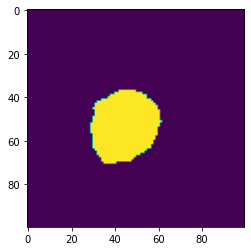

In [124]:
import nibabel as nib
from nilearn.image import resample_img
import pylab as plt
import nibabel as nb
import numpy as np

img = nib.load('/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/Optimizer_VTAs/Clinician/sub-CbctDbs0201_hemi-L.nii')

print(img.shape)
print(img.affine)
# downsampled_nii1 = resample_img(img, target_affine=np.eye(3)*0.1, target_shape=(21,21,27), interpolation='nearest')
# print(downsampled_nii1.shape)
plt.imshow(img.dataobj[:,:,40])

[[  0.1   0.    0.  -20. ]
 [  0.    0.1   0.  -23. ]
 [  0.    0.    0.1 -12. ]
 [  0.    0.    0.    1. ]]
(192, 192, 252)


/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_79976/3150115018.py:5: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  downsampled_nii = resample_img(img, target_affine=new_affine, interpolation='nearest')
/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_79976/3150115018.py:5: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  downsampled_nii = resample_img(img, target_affine=new_affine, interpolation='nearest')


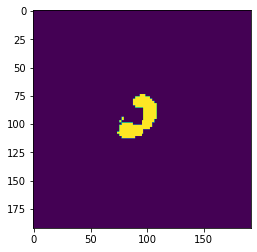

In [107]:
new_affine = img.affine / np.diag(img.affine)
voxel_res_mm = 0.1
new_affine[:3,:3] = new_affine[:3,:3] * np.eye(3) * voxel_res_mm
print(new_affine)
downsampled_nii = resample_img(img, target_affine=new_affine, interpolation='nearest')
print(downsampled_nii.shape)
plt.imshow(downsampled_nii.dataobj[:,:,126])

(71, 71, 71)
[[  0.32857144   0.           0.         -21.        ]
 [  0.           0.35714287   0.         -28.        ]
 [  0.           0.           0.47142857 -20.        ]
 [  0.           0.           0.           1.        ]]


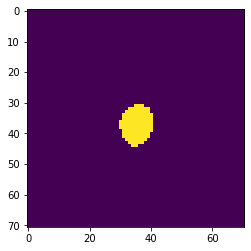

In [108]:
img2 = nib.load('/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/Optimizer_VTAs/Optimizer/sub-CbctDbs0201_hemi-L.nii')
plt.imshow(img2.dataobj[:,:,35])
print(img2.shape)
print(img2.affine)

[[  0.1   0.    0.  -21. ]
 [  0.    0.1   0.  -28. ]
 [  0.    0.    0.1 -20. ]
 [  0.    0.    0.    1. ]]


/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_79976/3557700067.py:6: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  downsampled_nii = resample_img(img2, target_affine=new_affine, interpolation='nearest')
/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_79976/3557700067.py:6: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  downsampled_nii = resample_img(img2, target_affine=new_affine, interpolation='nearest')


(232, 252, 332)


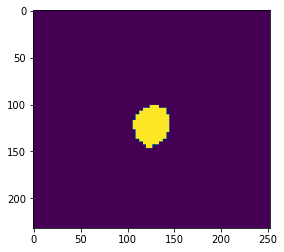

In [110]:
new_affine = img2.affine / np.diag(img2.affine)
voxel_res_mm = 0.1
new_affine[:3,:3] = new_affine[:3,:3] * np.eye(3) * voxel_res_mm
print(new_affine)

downsampled_nii = resample_img(img2, target_affine=new_affine, interpolation='nearest')
print(downsampled_nii.shape)
plt.imshow(downsampled_nii.dataobj[:,:,166])

(100, 100, 100)


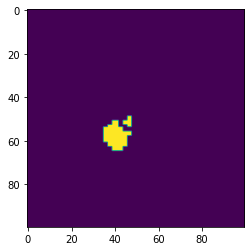

In [123]:
# Resample img2 to match img1's space
resampled_img2 = resample_img(
    img2,
    target_affine=img.affine,
    target_shape=img.shape,
    interpolation='nearest',
    force_resample=True,
    copy_header=True
)
print(resampled_img2.shape)
plt.imshow(resampled_img2.dataobj[:,:,40])

26.31828976171246